<a href="https://colab.research.google.com/github/AugustoBonifacio001/AugustoBonifacio001/blob/main/C%C3%B3pia_de_harmo_fft_cossenoipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

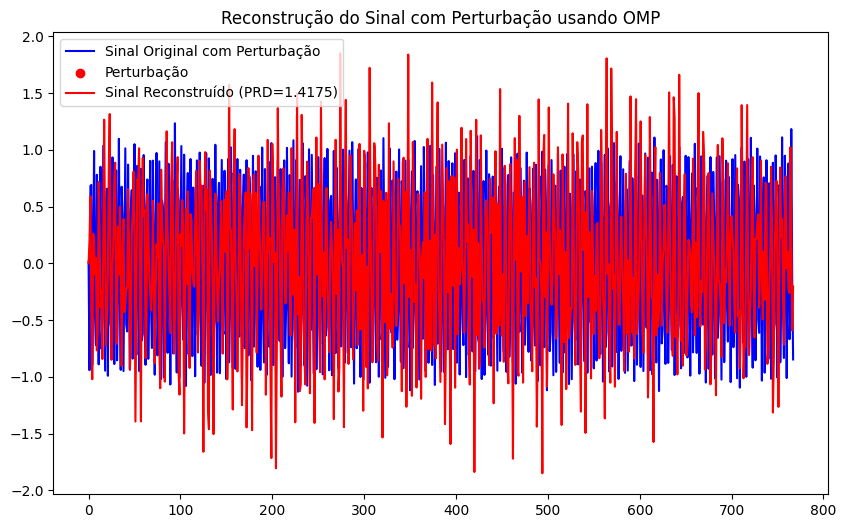

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import scipy.fftpack

def omp(Phi, u, s):
    omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs=s)
    omp_model.fit(Phi, u)
    return omp_model.coef_

def calculate_prd(original, reconstructed):
   return  np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum((original) ** 2))


def generate_perturbation(n, no, Npc, Vm1, SNRdb):
    k = 1
    a = np.random.uniform(400, 1000)
    freq = np.random.uniform(1000, 2500)
    n2 = 0
    periodo = Npc

    dist = np.zeros(n)
    x1 = np.sin(2 * np.pi *freq* np.arange(0, n))  # Definindo x1 fora da função
    for n1 in range(0, n):
        if n1 > no:
            dist[n1] = k * np.exp(-a * t[n2]) * np.sin(2 * np.pi * freq * t[n2])
            n2 += 1
            if n1 == (no + 100) and (n1 < Npc - periodo - 100):
                no = no + periodo
                a = np.random.uniform(400, 1000)
                freq = np.random.uniform(1000, 2500)
                n2 = 0
        if n1 <= no:
            dist[n1] = 0

    Ps = (Vm1 ** 2) / 2
    Pr = Ps / (10 ** (SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, n)
    R -= np.mean(R)
    xIn = np.zeros(768)
    xIn = x1[:len(xIn)]
    xIn += dist[:len(xIn)]
    xIn += R[:len(xIn)]

    return xIn, no, periodo, freq, dist  # Retornando também a perturbação (dist)

# Exemplo de uso:
SNRdb = 20
Npc = 256
t = np.arange(0, 768)
T = 1 / (Npc * 60)
xIn, no, Nc, freq , dist = generate_perturbation(len(t), 100, 256, 1, SNRdb)
Nc = 10
n = Nc*Npc

# Amostragem aleatória do sinal perturbado
p = 20
amostras_aleatorias = np.round((len(xIn)) * np.random.rand(p)).astype(int)
y = xIn[amostras_aleatorias]

# Aqui {y} = [C]{x} = [C][Phi]{s}, onde Phi é a transformada discreta do cosseno inversa
Phi = np.fft.fft(np.eye(len(t), len(t)))
CPhi = np.imag(Phi[amostras_aleatorias, :])
#Phi = scipy.fftpack.dct(np.eye(n), axis=0, norm='ortho')
#CPhi = Phi[amostras_aleatorias,:]


# OMP para minimização de l1
s_reconstruido = omp(CPhi, y, 10)  # obter o vetor esparso através do algoritmo OMP
x_rec = np.imag(np.fft.fft(s_reconstruido))
#x_rec = np.dot(Phi.T, s_reconstruido)
# Calcular o prd
prd_omp = calculate_prd(xIn, x_rec[:len(xIn)])

# Visualizar o sinal original com a perturbação, o sinal reconstruído e o erro
plt.figure(figsize=(10, 6))
plt.plot(t, xIn, 'b', label='Sinal Original com Perturbação')
plt.scatter(t[no], xIn[no], color='red', label='Perturbação')
plt.plot(t, x_rec[:len(xIn)], 'r', label=f'Sinal Reconstruído (PRD={prd_omp:.4f})')
plt.title('Reconstrução do Sinal com Perturbação usando OMP')
plt.legend()
plt.show()

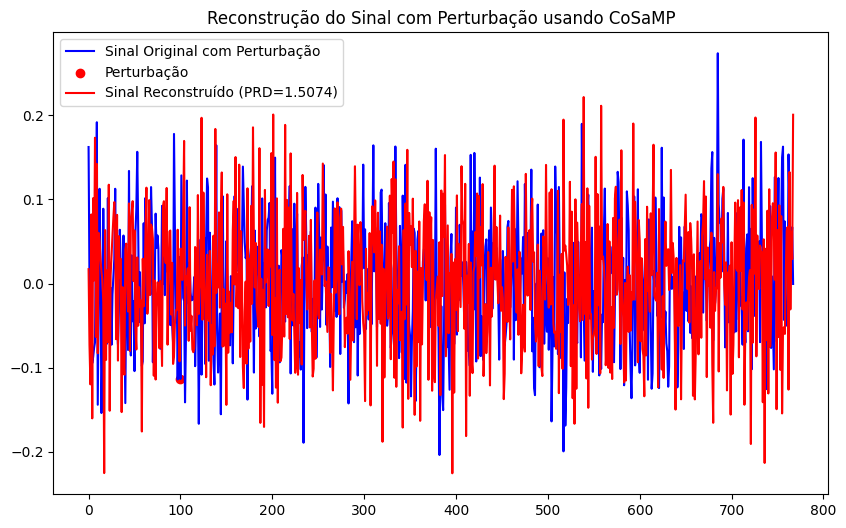

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.fftpack

def cosamp(A, y, s, max_iter=20, tol=1e-10):
    m, n = A.shape
    x = np.zeros(n)

    for _ in range(max_iter):
        # Multiplicação de matrizes com as dimensões corretas
        residual = y - A @ x

        # Ajuste nas dimensões para garantir compatibilidade
        residual = residual.reshape(-1, 1)

        indices = np.argsort(np.abs(A.T @ residual))[-2 * s:]
        Omega = np.union1d(indices, np.nonzero(x)[0])[:n]

        # Garantindo que os índices estejam dentro dos limites de x
        Omega = Omega[Omega < n]
        Omega = Omega[Omega < len(x)]

        # Correção nas dimensões de A
        def objective_function(x):
            return np.linalg.norm(A @ x - y)
        A_omega = A[:, Omega]

        x = np.zeros(n)
        initial_guess = np.zeros(len(Omega))  # Define um palpite inicial para a otimização
        constraints = {'type': 'eq', 'fun': lambda z: A_omega @ z - y}

        result = minimize(objective_function, initial_guess, constraints=[constraints])
        result.x = result.x.reshape(Omega.shape)

        indices = np.argsort(np.abs(result.x))[-s:]
        x[Omega] = result.x[indices[:len(Omega)]]

        if np.linalg.norm(y - A @ x) < tol:
            break

    return x


def calculate_prd(original, reconstructed):
   return  np.sqrt(np.sum((original - reconstructed) ** 2) / np.sum((original) ** 2))

def generate_perturbation(n, no, Npc, Vm1, SNRdb):
    k = 1
    a = np.random.uniform(400, 1000)
    freq = np.random.uniform(1000, 2500)
    n2 = 0
    periodo = Npc

    dist = np.zeros(n)
    x1 = np.sin(2 * np.pi *freq* np.arange(0, n))  # Definindo x1 fora da função
    FreqFund = 60
    t = np.arange(0, n)
    x1 = Vm1 * np.sin(2 * np.pi * FreqFund * t)

    for n1 in range(n):
        if n1 > no:
            dist[n1] = k * np.exp(-a * t[n2]) * np.sin(2 * np.pi * freq * t[n2])
            n2 += 1
            if n1 == (no + 100) and (n1 < Npc - periodo - 100):
                no = no + periodo
                a = np.random.uniform(400, 1000)
                freq = np.random.uniform(1000, 2500)
                n2 = 0
        if n1 <= no:
            dist[n1] = 0

    Ps = (Vm1 ** 2) / 2
    Pr = Ps / (10 ** (SNRdb / 10))
    desvio = np.sqrt(Pr)
    R = np.random.normal(0, desvio, n)
    R -= np.mean(R)
    xIn = np.zeros(768)
    xIn = x1[:len(xIn)]
    xIn += dist[:len(xIn)]
    xIn += R[:len(xIn)]

    return xIn, no, periodo, freq , dist


# Exemplo de uso:

SNRdb = 20
Npc = 256
t = np.arange(0, 768)
T = 1 / (Npc * 60)
xIn, no, Nc, freq , dist = generate_perturbation(len(t), 100, 256, 1, SNRdb)
Nc = 10
n = Nc*Npc

# Criando uma matriz esparsa usando amostras aleatórias da matriz de Fourier
# Aqui, Phi_sparse terá o mesmo número de linhas que y
Phi_sparse = np.fft.fft(np.eye(len(t)))[np.random.choice(len(t), len(xIn), replace=False)].T.real
#Phi = np.fft.fft(np.eye(len(t), len(t)))
#CPhi = np.imag(Phi[amostras_aleatorias, :])
Phi = scipy.fftpack.dct(np.eye(n), axis=0, norm='ortho')
CPhi = Phi[amostras_aleatorias,:]

# Amostragem aleatória do sinal com o ruído:
# Amostragem aleatória do sinal perturbado
p = 20
amostras_aleatorias = np.round((len(xIn)) * np.random.rand(p)).astype(int)
y = xIn[amostras_aleatorias]

# CoSaMP para minimização de l1:
s_reconstruido = omp(CPhi, y, 10)  # obter o vetor esparso através do algoritmo OMP
#x_rec = np.imag(np.fft.fft(s_reconstruido))
x_rec = np.dot(Phi.T, s_reconstruido)

# Calcular o MSE
prd_cosamp = calculate_prd(xIn, x_rec[:len(xIn)])

# Visualizar o sinal original com a perturbação, o sinal reconstruído e o erro
plt.figure(figsize=(10, 6))
plt.plot(t, xIn, 'b', label='Sinal Original com Perturbação')
plt.scatter(t[no], xIn[no], color='red', label='Perturbação')
plt.plot(t, x_rec[:len(xIn)], 'r', label=f'Sinal Reconstruído (PRD={prd_cosamp:.4f})')
plt.title('Reconstrução do Sinal com Perturbação usando CoSaMP')
plt.legend()
plt.show()

